In [19]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image


In [20]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [21]:
batch_size = 16
training_loader = DataLoader(training_data, batch_size, True)
test_loader = DataLoader(test_data, batch_size, True)

def encode_y(y):
    return nn.functional.one_hot(y, 10)

# for x, y in test_loader:
#     print(x.shape, y.shape, encode_y(y).shape)


In [22]:

# Функция отрисовки изображений из датасета
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])
        plt.imshow(image, "gray")
        plt.title(torch.argmax(labels[i]))
        plt.axis('off')
    plt.show()


# for batch_idx, (x, y) in enumerate(training_loader):
#     if batch_idx < 1:
#         show_images(x, encode_y(y))
#         break


In [35]:
class MyModel:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.flatten = nn.Flatten()
        w1 = torch.FloatTensor(784, 5)
        w2 = torch.FloatTensor(5, 10)

        self.w1 = Parameter(w1.uniform_(-0.01, 0.01))
        self.w2 = Parameter(w2.uniform_(-0.01, 0.01))

    def forward(self, input):
        v = self.flatten(input)
        v = torch.mm(v, self.w1)
        v = torch.relu(v)
        v = torch.mm(v, self.w2)
        return v

    def train(self, x, y, iter):
        value = self.forward(x)
        h = torch.sum((y - value)**2)

        if iter % 1000 == 0:
            print(f"loss: {h.data / batch_size}")

        h.backward()

        self.w1.data -= self.learning_rate * self.w1.grad.data
        self.w2.data -= self.learning_rate * self.w2.grad.data

        self.w1.grad.data.zero_()
        self.w2.grad.data.zero_()


model = MyModel(0.01)
for e in range(3):
    print(f"== Epoch: {e} ==")
    for iter, (x, y) in enumerate(training_loader):
        model.train(x, encode_y(y), iter)


== Epoch: 0 ==
loss: 1.0006020069122314
loss: 0.48775702714920044
loss: 0.6948037147521973
loss: 0.6399145126342773
== Epoch: 1 ==
loss: 0.33377766609191895
loss: 0.6135621666908264
loss: 0.6351657509803772
loss: 0.69095778465271
== Epoch: 2 ==
loss: 0.42620497941970825
loss: 0.6491106748580933
loss: 0.6645998358726501
loss: 0.4247102439403534


In [36]:
sum = 0
positive = 0
for iter, (x, y) in enumerate(test_loader):
    res = model.forward(x)
    sum += torch.sum((res - encode_y(y))**2).data
    # print(res.argmax(1), y)
    positive += (res.argmax(1) == y).type(torch.float).sum().item()
print(f"Test loss: {sum.data / len(test_data)}, accuracy: {positive / len(test_data)*100}%")

Test loss: 0.5573423504829407, accuracy: 49.69%


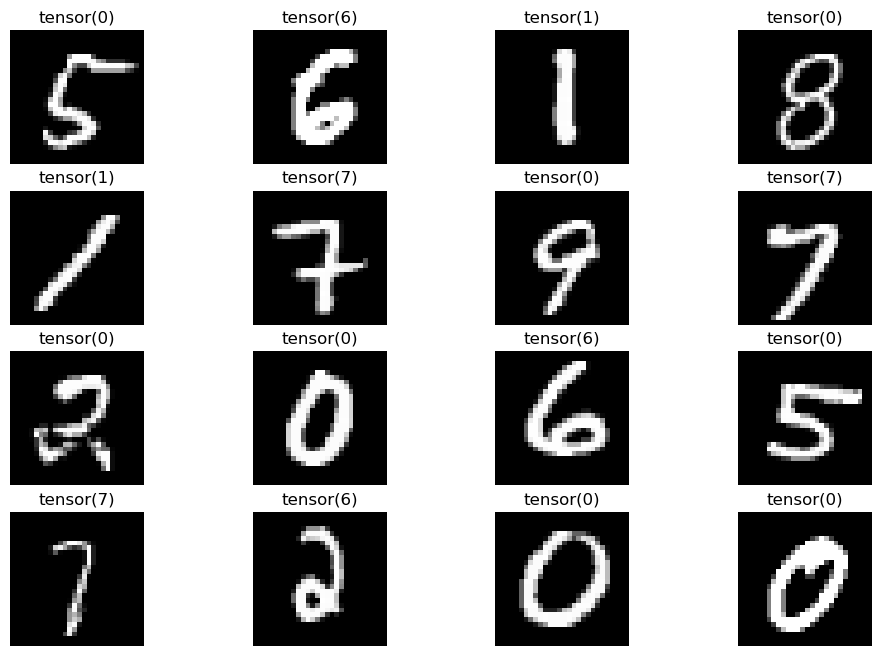

In [37]:
for batch_idx, (x, y) in enumerate(test_loader):
    if batch_idx < 1:
        show_images(x, model.forward(x).data)
        break